In [2]:
import os
import torch
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pprint import pprint
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pickle
import segmentation_models_pytorch as smp
import sys
sys.path.append('../src')
from utils import *
from datasets import *
from models import Segmentor
from models import Decoder
from pytorch_lightning.callbacks import EarlyStopping
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
dataset = Chorus_dataset("../data/processed/", split = 'train', init = True, transform = True)
test_dataset = Chorus_dataset("../data/processed/", split = 'test', init = True, transform = True)

In [4]:
dataset_len = int(len(dataset))
n = 40
train_dataset, val_dataset= torch.utils.data.random_split(dataset, [n, dataset_len-n])


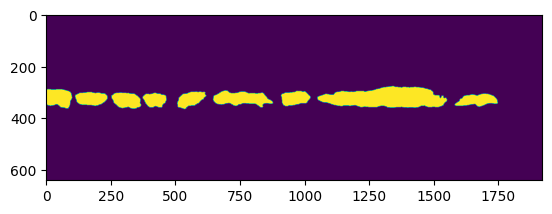

In [5]:
plt.imshow(test_dataset[1]['mask'].permute(1,2,0))

In [5]:
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=0)

In [6]:
model = Segmentor("FPN", "resnet34", in_channels=3, out_classes=1)
# decoder = Decoder().to(DEVICE)

# Set up the optimizer, hyperparameter tuning will improve performance here
lr = 1e-5
wd = 0
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
loss_fn = torch.nn.BCELoss()
# loss_fn = torch.nn.BCELoss()
#keys = list(bbox_coords.keys())
trainer = pl.Trainer(
    max_epochs=100,
    accelerator="gpu",
    gpus = [0], log_every_n_steps=1,
    logger=pl.loggers.TensorBoardLogger("logs/"),
    callbacks=[EarlyStopping(monitor='valid_f1_score', patience=20, mode = 'max')]
)

trainer.fit(
    model, 
    train_dataloaders=train_dataloader, 
    val_dataloaders = val_dataloader
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name    | Type     | Params
-------------------------------------
0 | model   | FPN      | 23.2 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
23.2 M    Trainable params
0         Non-trainable params
23.2 M    Total params
92.622    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/envs/segment_anything/lib/python3.11/site-packages/pytorch_lightning/trainer/data_loading.py:453: UserWarning: Your `val_dataloader` has `shuffle=True`,it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(
/opt/conda/envs/segment_anything/lib/python3.11/site-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 255 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/conda/envs/segment_anything/lib/python3.11/site-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 255 which is the number of cpus on this machine) in the `DataLoader

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/opt/conda/envs/segment_anything/lib/python3.11/site-packages/pytorch_lightning/trainer/trainer.py:685: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [7]:
# run validation dataset
valid_metrics = trainer.validate(model, dataloaders=val_dataloader, verbose=False)
pprint(valid_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Validating: 0it [00:00, ?it/s]

[{'valid_dataset_iou': 0.8604710698127747,
  'valid_f1_score': 0.9250034093856812,
  'valid_per_image_iou': 0.8330106735229492}]


In [8]:
# run test dataset
test_metrics = trainer.test(model, dataloaders=test_dataloader, verbose=False)
pprint(test_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/opt/conda/envs/segment_anything/lib/python3.11/site-packages/pytorch_lightning/trainer/data_loading.py:453: UserWarning: Your `test_dataloader` has `shuffle=True`,it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(
/opt/conda/envs/segment_anything/lib/python3.11/site-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 255 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

[{'test_dataset_iou': 0.47086071968078613,
  'test_f1_score': 0.6402519345283508,
  'test_per_image_iou': 0.5483459830284119}]


In [9]:
##save model weights
os.makedirs('weights', exist_ok = True)
torch.save(model.state_dict(), 'weights/segmentor_random.pth')

In [10]:
# model.load_state_dict(torch.load('weights/segmentor.pth'))

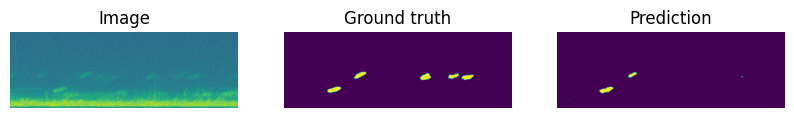

In [11]:
batch = next(iter(test_dataloader))
with torch.no_grad():
    model.eval()
    logits = model(batch["image"])
pr_masks = logits.sigmoid()

for image, gt_mask, pr_mask in zip(batch["image"], batch["mask"], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()
     